# Projet Leyenda
## I. Introduction
### 1.1 Introduction au projet

L’entreprise TouNum fait appel à nos services afin d’ajouter à leurs prestations un algorithme de Machine Learning permettant d’améliorer les performances de numérisation de leurs clients. Le premier contrat concerne une solution visant à analyser des photographies afin d’en écrire une légende descriptive automatique, en suivant le concept de captioning.

Cette mission implique plusieurs enjeux : dans un premier temps, les images étant de qualité, définition et résolution pouvant être variables, il faudra nettoyer l’image. De plus, comme ceux-ci comptent travailler sur des types de documents différents, il sera important de savoir trier les documents en question.

![](Images/workflow_projet.png)

Ci-dessus, le Workflow fournit par Tounum. Pour implémenter les algorithmes, nous utiliserons Python (sous forme d’un Notebook Jupyter) ainsi que les librairies SciKit et TensorFlow. D’un point de vue plus mathématique, nous utiliserons également NumPy et MatPlotLib.

Tounum nous fournit également un Dataset dans lequel des images déjà catégorisées permettront d’entraîner nos algorithmes. Dans un premier temps, nous effectuerons une classification binaire via un réseau de neurones afin de classer les fichiers en 2 classes : photos et autres images. Il faudra donc différencier les photos des schémas ainsi que des peintures par exemple.

Pour le captioning, 2 techniques de Machine Learning sont à utiliser. Dans un premier temps, les réseaux de neurones convolutifs, CNN, afin de prétraiter les images. Par la suite, des réseaux de neurones récurrents, RNN, pour générer les étiquettes (descriptions).

Une autre contrainte est à prendre en compte, notamment l’automatisation complète du processus, de l’insertion du jeu de données jusqu’à la création des étiquettes.

3 livrables seront à rendre respectivement fin de semaine 3, fin de semaine 4 et fin de semaine 5 :

- Livrable 1 : Classification Binaire.

- Livrable 2 : Traitement d’images.

- Livrable 3 : Captioning d’images.

Dans ce notebook, vous trouverez le code ainsi que les justifications techniques complètes concernant le livrable 2 sur le débruitage des images.


### 1.2 Notre équipe de Bordeaux

L'équipe est composé d'étudiants de CESI en option **Data Science** composée de :
- Elise Beaumatin
- Axel Brosset
- Gaylord Giret
- Xavier Labarbe
- Mathieu Musard

### 1.3 Introduction au livrable 2 : Débruitage des images

Lors de notre précédent livrable, nous avons établis un algorithme de classification binaire permettant d’identifier les photographies parmi un ensemble d’images. Via l’apprentissage d’un groupe de photos donné, nous avons obtenu une précision de **99%**. A la suite du livrable 1 nous récupérons donc un ensemble de photos, avec un taux d’erreur de 1%. Nous passons donc à la prochaine étape du traitement. 

Ce notebook nous permettra de présenter le travail effectué sur le livrable 2. L’objectif de ce livrable est de traiter des photographies afin d’améliorer leur efficacité et précision lors d’utilisation d’algorithmes de Machine Learning et Deep Learning.  

Pour ce faire nous développerons un algorithme qui débruitera les images via un auto-encodeur. Cela permettra d’améliorer la qualité d’informations nos photos, apportées une homogénéité de la précision sur toutes les images et on pourra faire un meilleur traitement pour la suite.  

## II. Importations des modules et des données

### 2.1 Importation des modules

La première chose à faire pour faire fonctionner ce notebook et espèrer modéliser les données avec les dernières techniques de machine learning tout en exploitant la puissance de certaines librairies Python comme NumPy, TensorFlow et matplotlib, est d'installer et d'importer les librairies Python que nous allons utiliser dans ce notebook. Préalablement, il convient d'installer ces librairies dans notre environnement d'execution avec les commandes **'!pip install'** ou **'!conda install'**, conformément aux instructions indiquées sur les sites de ces librairies. Une fois installées, nous pouvons importer les librairies dans le notebook. Vous pouvez trouvez toutes les librairies que nous avons utilisées dans le bloc de code ci-dessous.




In [1]:
# --- Libraries for preparing and importing data --- # 

import os                          
from zipfile import ZipFile       
from PIL import Image              
import shutil                      
import glob    

# --- Libraries for creating AI model and for handling data --- # 

import tensorflow as tf            
import numpy as np                
from tensorflow import keras       
from keras import layers           
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0
from sklearn.model_selection import train_test_split
from keras import backend as K

# --- Libraries for plotting data --- # 

import plotly.express as px        
import matplotlib.pyplot as plt    
from keras.utils import plot_model

# --- Libraries for GPU usage --- # 

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

# --- Definition of colors code for Jupyter Notebooks (For printing purpose) --- #

yellow = '\033[93m'
green = '\033[92m'
red = '\033[91m'
default = '\033[39m'


# Creates a config object from the ConfigProto class
config = ConfigProto()

# Allows GPU memory growth
config.gpu_options.allow_growth = True

# Creates an interactive session with the specified config
session = InteractiveSession(config=config)

### 2.2 Récupération des données

Une fois que nous avons toutes nos librairies, nous allons devoir récupérer les données nécessaires à la réalisation du notebook. En science des données, il existe plusieurs moyens d'obtenir des données. Il est possible de s'appuyer sur des données locales (par exemple des fichiers plat sur notre machine), d'interroger des bases de données, d'interroger des API (Application Programming Interface), ou encore d'extraire des données depuis des sites Web. Dans notre cas le jeu de données est fournis par le CESI à l'URL suivant :   

https://cesifr-my.sharepoint.com/:u:/g/personal/cmeslin_cesi_fr/EZuPZuL19sdLv39Xjvs_S9sBUjUAz2jrRLg37hwctCybFQ?e=UQzPuc

Il s'agit d'une archive au format Zip qui contient un dossier avec toutes les images. Pour créér un jeu de données tensorflow à partir de ces images il va falloir les extraires les images des archives.

Afin de préparer les images à leur utilisation par ce notebook, il faut créer un répertoire à l'emplacement désiré et y déposer l'archive contenant le dataset. Voir l'exemple sur l'image suivante. (**Attention ! Une archive doit contenir un ou plusieurs dossier contenant les images, les images ne doivent pas être à la racine de l'archive**)

![](https://i.ibb.co/xCvbyck/image.png)

### 2.3 Extraction des données

Maintenant que nous avons créé un répertoire avec l'archive qui contient les images, nous pouvons exécuter le code qui permettra d'extraire les images et les organiser dans un dossier.

In [2]:
# --- Definition of variables --- #

allow_extraction = False # Boolean : 'True' will extract the data and 'False' will prevent data from being extracted.
datasets_path = r"C:\Users\axelb\Desktop\Projet DS\Datasets_l2" # String : Path to the folder containing the datasets (in ZIP format). 

extracted_datasets_path = os.path.join(datasets_path,'Extracted')  # String : Path to the folder where images will be extracted. 

# --- Algorithm for extracting images from the achives --- #

if allow_extraction: # If the extraction if images is on True
    if not os.path.exists(extracted_datasets_path): # If the extraction folder isn't created yet
        os.makedirs(extracted_datasets_path) # Creation of the extraction folder
        print(f"{green}Extraction folder successfully created at '{extracted_datasets_path}'")
                
    try: # Try catch used to ignore an error at the end of the execution.
        for dataset_filename in os.listdir(datasets_path): # For all archives in the dataset folder. 
            file_extension = os.path.splitext(dataset_filename)[1] # Retrieve the extension of the current file
            if file_extension == ".zip": # If the file is a zip file
                dataset_path = os.path.join(datasets_path, dataset_filename) # Retrieve the complete path of the archive.
                dataset_zip = ZipFile(dataset_path, 'r') # Create a ZipFile object from the archive. 
                print(f"Starting the extraction of '{dataset_filename}' at '{extracted_datasets_path}'")
                dataset_zip.extractall(extracted_datasets_path) # Extract the dataset in the extraction path
                print(f"{green}'{dataset_filename}' was successfully extracted at '{extracted_datasets_path}'")
                dataset_zip.close() # Close the archive
    except:
        pass
            
    print("All the images has been extracted")

Une fois le code exécuté, nous nous retrouvons avec un dossier nommé "Extracted_l2" qui contient lui même dun dossier avec les images à l'intérieur.

### 2.4 Préparation des données

Il manque maintenant une dernière étape avant d'importer ces données dans un jeu de données TensorFlow. Il s'agit de vérifier que tous les fichiers dans les réportoires contenant les données sont des images et qu'elles peuvent toutes être traitées par dans un code Python. Pour cela nous allons vérifier que toutes les images sont ouvrables avec une librairie conçue pour gérer les images en Python (PIL). Les fichiers qui rencontreront des erreurs d'ouvertures seront supprimés.


In [3]:
# --- Definition of variables --- #

# Define an empty list to store images
dataset = []

# --- Algorithm for searching corrupted images --- #

# Retrieve the list of path for all images in the specified folder
img_paths = glob.glob(os.path.join(r"C:\Users\axelb\Desktop\Projet DS\Datasets_l2\Extracted",'*/*.*')) 
# For all images
for image_path in img_paths: 
    try:
        # Read the image with TensorFlow and transform it in an array
        decoded_img = tf.io.decode_jpeg(tf.io.read_file(image_path), channels = 3)
        # Resize the image to (384,384)
        resized_img = tf.image.resize(decoded_img, (384,384))
        # Append the image to the dataset
        dataset.append(resized_img)
    except tf.errors.InvalidArgumentError as e: # If there is an error when opening an image
        # Print the error message
        print(f"{red}ERROR : Dropping the file at {image_path} because it can't be open...")
        # Remove the image from the dataset
        os.remove(image_path) 
# Print a message after all the images have been analyzed
print(f"{default}All the images has been analysed")


All the images has been analysed


### 2.5 Importation des données

Maintenant que toutes les images sont prêtes, nous pouvons les importer dans un jeu de données TensorFlow. Pour cela nous allons utiliser la méthode **"image_dataset_from_directory"**. Cette méthode permet de créer un jeu de données à partir d'un répertoire contenant un ou plusieurs dossiers avec des images.

Afin de pouvoir entrainer le modèle et le tester sur des données différentes, nous avons répartis ces images en deux jeux de données disctincts. Le jeu de données de test ne sera jamais utilisé pour l'entrainement et vice versa. Pour cela nous utilisant le paramtère **"subset=both"**.    

Lors de l'importation des images, nous devons définir qu'elle sera leur taille dans le jeu de données (elles seront automatiquement redimensionnées par la méthode **"image_dataset_from_directory"**).

In [4]:
# Split the dataset into a training set and a test set
# 20% of the images will be used for the test set and the rest for the train set
# The images will be shuffled randomly and the random seed is set to 10
train_set, test_set = train_test_split(dataset, test_size=0.2, shuffle=True, random_state=10)

# Normalize the values of the images by dividing them by 255
train_set = np.array(train_set).astype('float32') / 255.
test_set = np.array(test_set).astype('float32') / 255.

print(f"There are {len(train_set)} images in the train set")
print(f"There are {len(test_set)} images in the train set")
print(f"The shape of one image is {train_set[0].shape}")


There are 120 images in the train set
There are 30 images in the train set
The shape of one image is (384, 384, 3)


Les images sont maintenant toutes réparties dans le jeu de données d'entrainement ou le jeu de données de test. Nous pouvons le vérifier en affichant certaines images de notre jeu d'entrainement. 

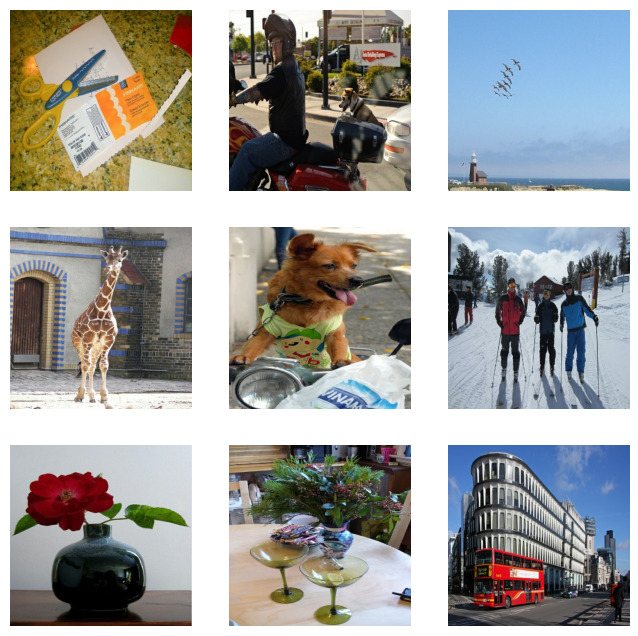

In [5]:
plt.figure(figsize=(8, 8)) # Create drawing figure with size 8x8
for i in range(9): # Loop over each image in the batch
    ax = plt.subplot(3, 3, i+1) # Add subplot to the drawing figure for the image
    plt.imshow(train_set[i]) # Display image using Matplotlib's imshow function
    plt.axis("off") # Turn off image axes
plt.show() # Display the drawing

### 2.6 Création d'images bruitées

Nous avons désormais un dataset réparti est prêt au traitement. Nous allons commencer par bruité volontairement les photos. **dire pourquoi**

Le bruit d’une image représente tout parasite ou dégradation que subit l’image lors de l’acquisition d’une photo. On parle de bruit numérique pour désigner l’ensemble des éléments qui peuvent dégrader une image. 

Lors d’un auto-encodeur de dé-bruitage, on bruite volontairement les images pour créer une imprécision, un défaut à la photo afin que l’algorithme apprenne à rétablir une image sans bruit. Cela permettra de garder uniquement les informations nécessaires pour la suite du traitement est d’enlever tout parasite.

Il existe différents types de bruit, bruit de photon, de lecture, de bande, de grain ou encore de thermoeclectron. Au niveau de ce qu'il se passe numériquement sur les pixels ont peut les résumés en deux principales catégories :
* Un bruit uniforme sur l’ensemble ou une partie des pixels, représenté par une variable finie 
* Un bruit dépendant de la valeur des pixels  

Nous utiliserons une fonction qui ajoutera une valeur aléatoire sur chaque pixel. **dire qu'on a utilisé gauss et pourquoi**

In [9]:
# Define a function that applies Gaussian noise to an image dataset
def apply_gaussian_noise(X, sigma=0.2):
    # Generate noise with mean 0 and standard deviation sigma
    noise = np.random.normal(loc=0.0, scale=sigma, size=X.shape)
    # Add the noise to the image dataset
    X += noise
    # Clipping the value of X between 0 and 1 
    X[X>1] = 1.0
    X[X<0] = 0.0
    # Return the noised dataset
    return X

# Create a copy of the original train and test sets and apply Gaussian noise to them
x_train_noisy = apply_gaussian_noise(train_set.copy())
x_test_noisy = apply_gaussian_noise(test_set.copy())


Nous pouvons afficher les mêmes images une fois le bruit ajouté et visualiser la différence sur la qualité des images.

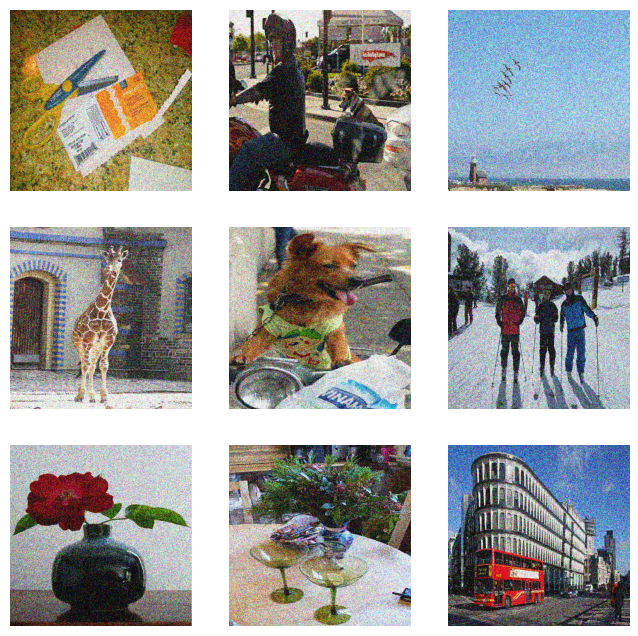

In [10]:
plt.figure(figsize=(8, 8)) # Create drawing figure with size 8x8
for i in range(9): # Loop over each image in the batch
    ax = plt.subplot(3, 3, i+1) # Add subplot to the drawing figure for the image
    plt.imshow(x_train_noisy[i]) # Display image using Matplotlib's imshow function
    plt.axis("off") # Turn off image axes
plt.show() # Display the drawing

Comme nous pouvons le remarquer, les photos sont plus pixélisés, elles ont perdus de leur vivacité, les couleurs sont saturés. Le bruit a bien été ajouté.

## III. Modélisation d'autoencodeurs pour le débruitage des images

Les auto-encodeurs sont des réseaux de neurones artificiels qui ont été largement utilisés dans le domaine du Deep Learning. Ils ont été initialement introduits dans les années 1980 et ont été utilisés principalement pour la réduction de la dimensionnalité des données. Leur objectif est de créer une représentation de données de dimension réduite qui est tout aussi informative que la représentation d'origine. 


Un auto-encodeur est généralement constitué de deux parties : un encodeur et un décodeur. L'encodeur est utilisé pour encoder les données d'entrée dans une représentation de dimension réduite, tandis que le décodeur est utilisé pour décoder cette représentation de dimension réduite en une reconstruction des données d'entrée. Le modèle est entraîné en utilisant une fonction de perte qui mesure la différence entre les données d'entrée et la reconstruction. L'idée est que, en entraînant le modèle à réduire cette différence, il apprend également à capturer les caractéristiques les plus importantes des données d'entrée. 


Les auto-encodeurs ont été utilisés dans de nombreuses applications, notamment la réduction de la dimensionnalité des données, l'apprentissage non supervisé, la génération de données, la segmentation d'image et la génération d'images. Les auto-encodeurs Variationnel (VAE) et Génératifs Adversariels (VAE) sont devenus populaire dans les dernières années, où l'objectif est de générer des données qui ressemble à celle d'origine. Les auto-encodeurs à Attention (Attention Auto-Encoder) ont été introduits et ils ont démontré de bons résultats dans les tâches de traitement de langue naturelle en permettant de s'attarder sur les parties les plus pertinentes de l'entrée. Les architectures de Transformer ont également été utilisées pour améliorer les résultats des auto-encodeurs. 
 

Les auto-encodeurs s’accordent cependant sur le même défaut : ils sont très sensibles aux bruits dans les données (d’où le traitement du bruit de nos images) et sont assez difficiles à entraîner sur des jeux de données volumineux et complexes. Ce dernier point joue en notre faveur, puisque le jeu de données est assez simple et léger, avec 150 fichiers uniquement.  **???**

### 3.1 Autoencodeur simple

Nous allons commencer par développer un auto-encodeur simple. **refprmulé**

Les auto-encodeurs simples sont des réseaux de neurones traditionnels qui utilisent des couches fully-connected pour encoder et décoder les données. Ils sont généralement utilisés pour les données qui ont une structure linéaire, comme les données tabulaires.

##### 3.1.1 Définition du modèle

Nous définissons dans cette partie les différentes couches du modèle et chaque élément nécessaire.

Tout d'abord nous pouvons retrouvé la partie encodeur de notre modèle :
* On définit les données d'entrées de notre réseau, ici, il s'agira d'images de 384 pixels de large et 384 pixels de haut avec 3 canaux de couleur (RGB)
* La première couche de notre réseau (Flatten) est une étape permettant d'aplatir les données d'entrée en un vecteur 1D. cela consiste à transformer les données de (384,384,3) en une seule dimension, ce qui va permettre de les traiter en utilisant les couches "fully-connected", ou "pleine".
* La deuxième couche de notre réseau (Dense) est une couche dites "fully-connected", ou "pleine", c'est-à-dire que chaque neurone de cette couche est relié à l'ensemble des neurones de la couche précédente. Elle est composée de 256 neurones et on fait appel à une fonction d'activation. Il en existe plusieurs :
    * La fonction d'activation ReLu (Rectified Linear Unit) est utilisée pour que les résultats de la couche soient positifs, ce qui permet de traiter les données de manière plus efficace.
    * **RAJOUT**
  Après des tests, nous avons choisis de faire appel à la fonction "**A RAJOUTER AVEC EXPLICATION**
* La troisième couche de notre réseau est également une couche pleine faisant appel à la fonction d'activation "**RAJOUT**". Cette couche est composé de 64 neurones. Elle représente la partie "encodeur" du réseau.
* La quatrième et la cinquième couche de notre réseau (Dense) sont des couches pleins avec respectivement 256 et 442368 neurones. Elles utilisent la même fonction d'activation "**RAJOUT**". Elles servent à décoder les données. **PK ce nombre de neurones**
* La dernière couche (Reshape) est utilisé pour redimensionner le vecteur décodé en une forme d'image de (384, 384, 3) pour correspondre à la forme d'entrée. Cela permet de retrouver la forme d'origine des données.

In [11]:
# Define the input layer of the model with the shape of the input images (384,384,3)
model_input = keras.Input(shape=(384, 384, 3))

# Flatten the input layer
x = layers.Flatten()(model_input)

# Add a dense layer with 256 units and ReLU activation
x = layers.Dense(256, activation='relu')(x)

# Add another dense layer with 64 units, this will be the encoded representation of the input
encoded = layers.Dense(64, activation='relu')(x)

# Add a dense layer with 256 units and ReLU activation
x = layers.Dense(256, activation='relu')(encoded)

# Add a dense layer with 442368 units and ReLU activation
x = layers.Dense(442368, activation='relu')(x)

# Add a reshape layer to reshape the output to the original image shape (384,384,3)
decoded = tf.keras.layers.Reshape(target_shape=(384,384,3))(x)

##### 3.1.2 Compilation du modèle

Dans cette partie nous compilerons le modèle.

Nous faisons appel à l'algorithme d'optimisation ADAM, un optimiseur d'apprentissage automatique qui adapte les taux d'apprentissage pour chaque paramètre en utilisant des mécanismes d'estimation des moyennes et des variances mobiles exponentielles. Il est souvent utilisé pour des modèles de réseaux de neurones profonds et connu pour sa vitesse de convergence vers une solution optimale.

Nous utilisons la fonction de perte "MeanSquaredError". Elle utilisée pour les problèmes de régression. Elle mesure la différence entre les prédictions du modèle et les valeurs cibles. Plus précisément, elle calcule la moyenne des erreurs au carré entre les prédictions du modèle et les valeurs cibles pour chaque élément d'entrée. En utilisant cette fonction de perte, le modèle apprend à minimiser la moyenne des erreurs au carré entre ses prédictions et les valeurs cibles, ce qui le rend efficace pour les tâches de prédiction de valeurs continues telles que la prédiction de prix de vente de maisons ou la prédiction de températures.

**Expliquer MAE**

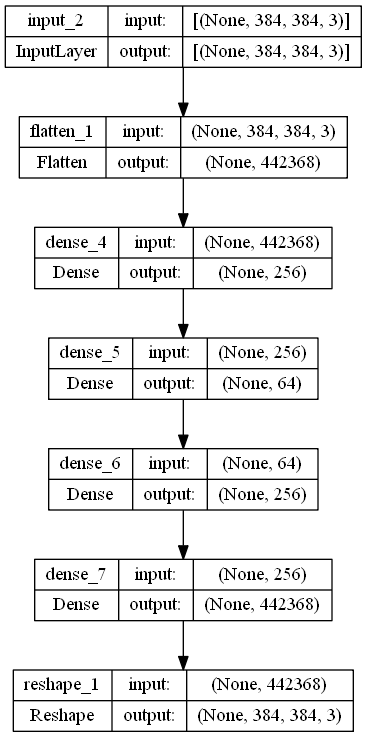

In [12]:
# Create the autoencoder model
autoencoder = keras.Model(model_input, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=["mae"])

# Plot the model architecture
plot_model(autoencoder, show_shapes=True)

##### 3.1.3 Entrainement du modèle

Ce code permet d'entrainer le modèle sur notre jeu de données d'entrainement, et de faire le processus de validation pour connaitre la performance du modèle sur des données qu'il ne connait pas.
**Plus d'explication**

In [13]:
# Set the number of training epochs
epochs = 20

# Train the model
history = autoencoder.fit(
    x_train_noisy, # Input data (noisy version of x_train)
    train_set,     # Target data (original x_train)
    batch_size=10, # Number of images per gradient update
    validation_data=(x_test_noisy, test_set), # Data to use for evaluation
    epochs=epochs, # Number of training iterations
    shuffle=True,  # Shuffle the input data before each epoch
)


Epoch 1/20
12/12 [==============================] - 2s 85ms/step - loss: 0.9802 - mae: 0.5900 - val_loss: 0.2605 - val_mae: 0.4387
Epoch 2/20
12/12 [==============================] - 1s 66ms/step - loss: 0.2737 - mae: 0.4407 - val_loss: 0.2450 - val_mae: 0.4195
Epoch 3/20
12/12 [==============================] - 1s 67ms/step - loss: 0.2593 - mae: 0.4242 - val_loss: 0.2292 - val_mae: 0.3998
Epoch 4/20
12/12 [==============================] - 1s 67ms/step - loss: 0.2481 - mae: 0.4120 - val_loss: 0.2270 - val_mae: 0.3991
Epoch 5/20
12/12 [==============================] - 1s 67ms/step - loss: 0.2393 - mae: 0.4033 - val_loss: 0.2110 - val_mae: 0.3786
Epoch 6/20
12/12 [==============================] - 1s 66ms/step - loss: 0.2271 - mae: 0.3882 - val_loss: 0.2053 - val_mae: 0.3703
Epoch 7/20
12/12 [==============================] - 1s 67ms/step - loss: 0.2231 - mae: 0.3826 - val_loss: 0.2070 - val_mae: 0.3733
Epoch 8/20
12/12 [==============================] - 1s 66ms/step - loss: 0.2237 - m

##### 3.1.4 Résultat du modèle

**mettre texte**

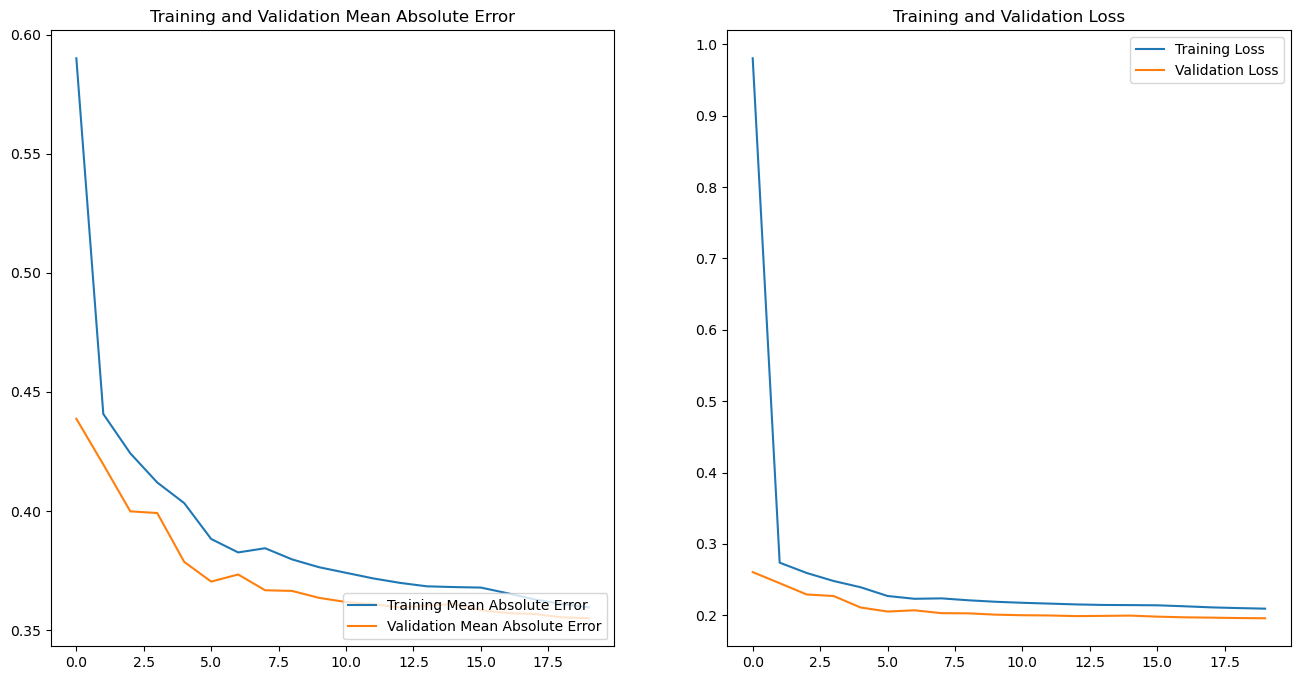

In [14]:
# Retrieve training and validation accuracy and loss history
acc = history.history['mae']
val_acc = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs) # Generate range of epochs
plt.figure(figsize=(16, 8)) # Create figure with subplots

# Add first subplot showing training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Mean Absolute Error')
plt.plot(epochs_range, val_acc, label='Validation Mean Absolute Error')
plt.legend(loc='lower right')
plt.title('Training and Validation Mean Absolute Error')

# Add second subplot showing training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**explication loss**

**FAIRE PARTIE ETUDES DE CAS**

1/1 [==============================] - 0s 81ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


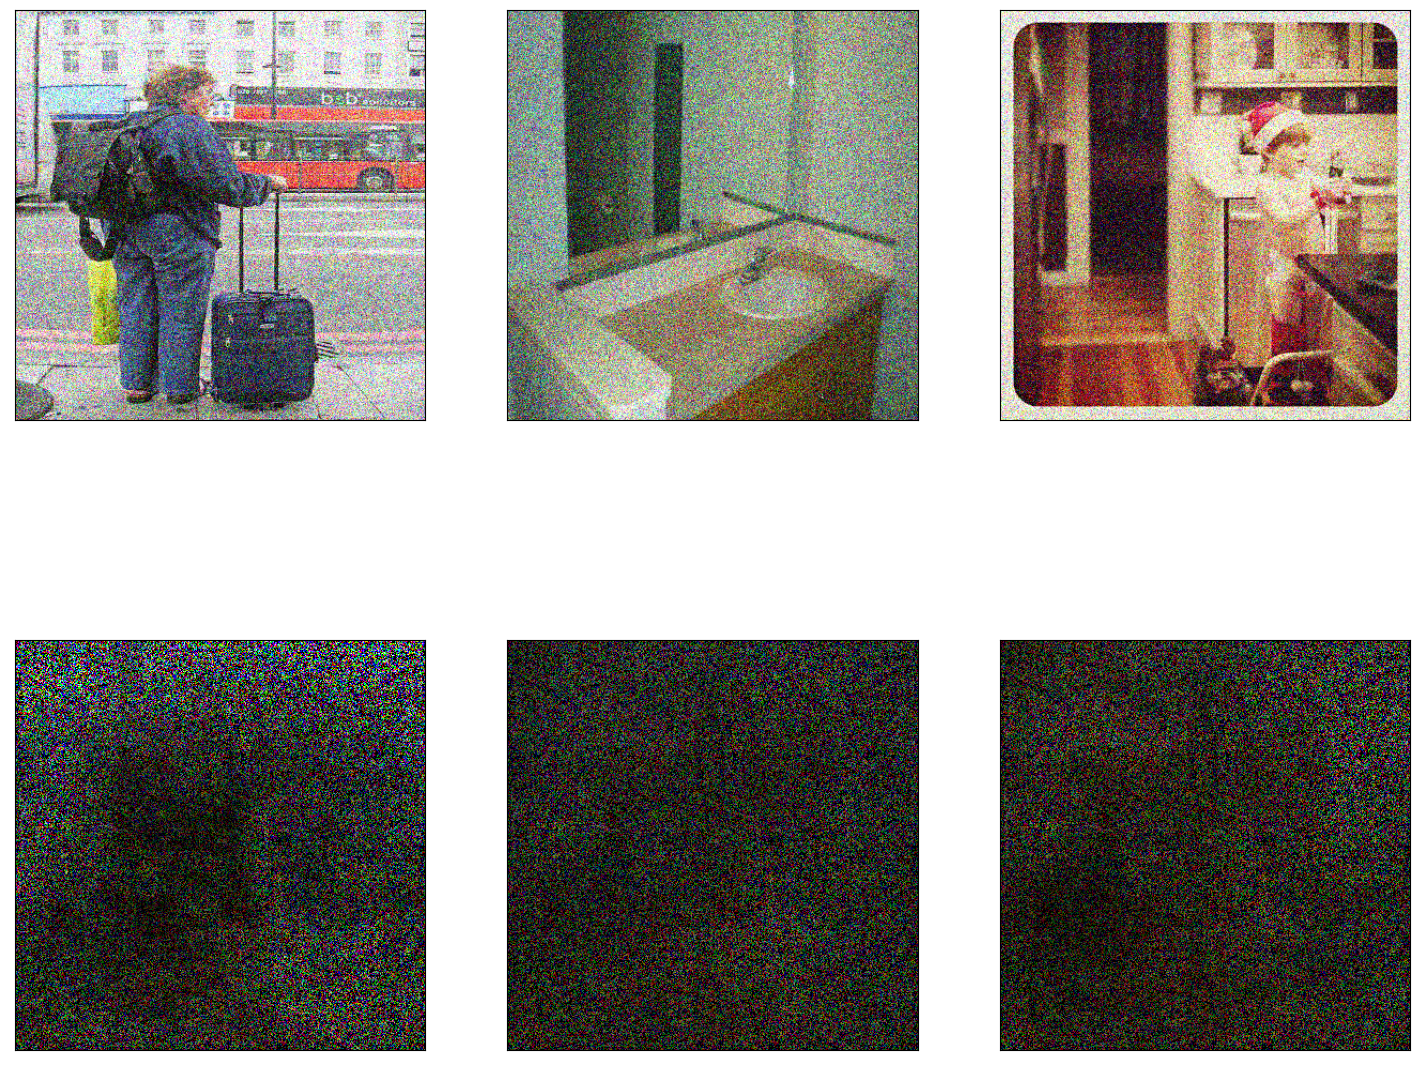

In [15]:
# Specify the number of test images to display
n = 3

# Create a figure with 2 rows and n columns
plt.figure(figsize=(18, 15))

# Use the autoencoder to predict the output of the test set
predictions = autoencoder.predict(x_test_noisy[:n])

# Plot the original and reconstructed images
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Show the plot
plt.show()

**bilan du modèle**

### 3.2 Autoencodeur convolutif

##### 3.2.1 Définition du modèle

In [13]:
# Define the input layer for the model
model_input = keras.Input(shape=(384, 384, 3))
# Add a convolutional layer with 16 filters, kernel size 3x3, and 'same' padding
x = layers.Conv2D(16, 3, padding='same')(model_input)
# Add a max pooling layer
x = layers.MaxPooling2D()(x)
# Add a convolutional layer with 64 filters, kernel size 3x3, and 'same' padding
x = layers.Conv2D(64, 3, padding='same')(x)
# Add a max pooling layer
x = layers.MaxPooling2D()(x)
# Add a convolutional layer with 256 filters, kernel size 3x3, 'same' padding and ReLU activation
encoded = layers.Conv2D(256, 3, activation='relu', padding='same')(x)

# Add a convolutional layer with 64 filters, kernel size 3x3, and 'same' padding
x = layers.Conv2D(64, 3, padding='same')(encoded)
# Add an UpSampling2D layer
x = layers.UpSampling2D()(x)
# Add a convolutional layer with 16 filters, kernel size 3x3, and 'same' padding
x = layers.Conv2D(16, 3, padding='same')(x)
# Add an UpSampling2D layer
x = layers.UpSampling2D()(x)
# Add a convolutional layer with 3 filters, kernel size 3x3, and 'same' padding
decoded = layers.Conv2D(3, 3, padding='same')(x)


##### 3.2.2 Compilation du modèle

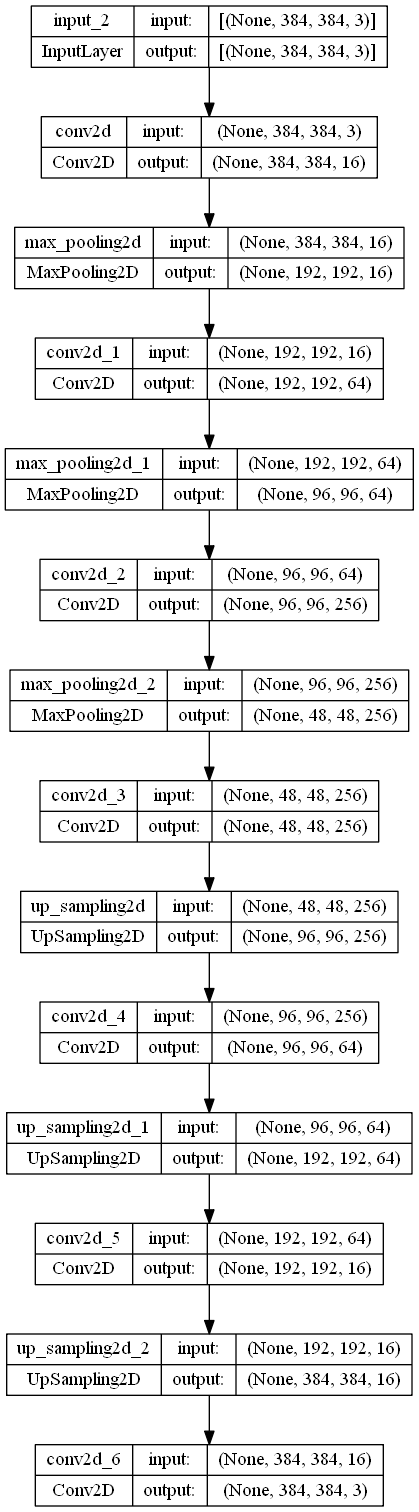

In [16]:
# Create the autoencoder model
autoencoder = keras.Model(model_input, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=["mae"])

# Plot the model architecture
plot_model(autoencoder, show_shapes=True)


##### 3.2.3 Entraînement du modèle

In [17]:
# Exécution du modèle
epochs = 40
history = autoencoder.fit(
    x_train_noisy,train_set, batch_size=10, validation_data=(x_test_noisy,test_set), epochs=epochs, shuffle=True,
)

Epoch 1/20
12/12 [==============================] - 2s 126ms/step - loss: 0.0639 - mae: 0.1880 - val_loss: 0.0185 - val_mae: 0.1041
Epoch 2/20
12/12 [==============================] - 1s 106ms/step - loss: 0.0202 - mae: 0.1056 - val_loss: 0.0135 - val_mae: 0.0864
Epoch 3/20
12/12 [==============================] - 1s 105ms/step - loss: 0.0148 - mae: 0.0882 - val_loss: 0.0092 - val_mae: 0.0673
Epoch 4/20
12/12 [==============================] - 1s 105ms/step - loss: 0.0114 - mae: 0.0745 - val_loss: 0.0079 - val_mae: 0.0606
Epoch 5/20
12/12 [==============================] - 1s 105ms/step - loss: 0.0100 - mae: 0.0678 - val_loss: 0.0073 - val_mae: 0.0567
Epoch 6/20
12/12 [==============================] - 1s 106ms/step - loss: 0.0094 - mae: 0.0645 - val_loss: 0.0068 - val_mae: 0.0535
Epoch 7/20
12/12 [==============================] - 1s 105ms/step - loss: 0.0090 - mae: 0.0627 - val_loss: 0.0066 - val_mae: 0.0527
Epoch 8/20
12/12 [==============================] - 1s 106ms/step - loss: 0.

##### Résultat du modèle

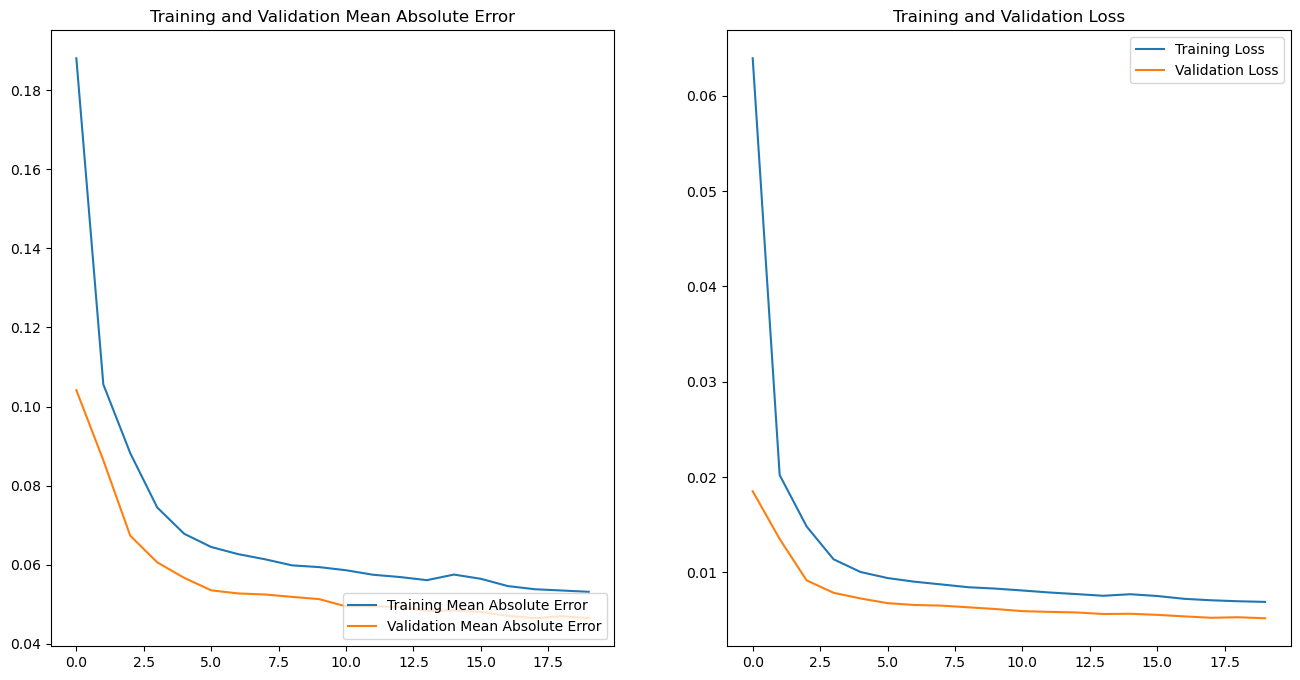

In [19]:
# Retrieve training and validation accuracy and loss history
acc = history.history['mae']
val_acc = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs) # Generate range of epochs
plt.figure(figsize=(16, 8)) # Create figure with subplots

# Add first subplot showing training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Mean Absolute Error')
plt.plot(epochs_range, val_acc, label='Validation Mean Absolute Error')
plt.legend(loc='lower right')
plt.title('Training and Validation Mean Absolute Error')

# Add second subplot showing training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


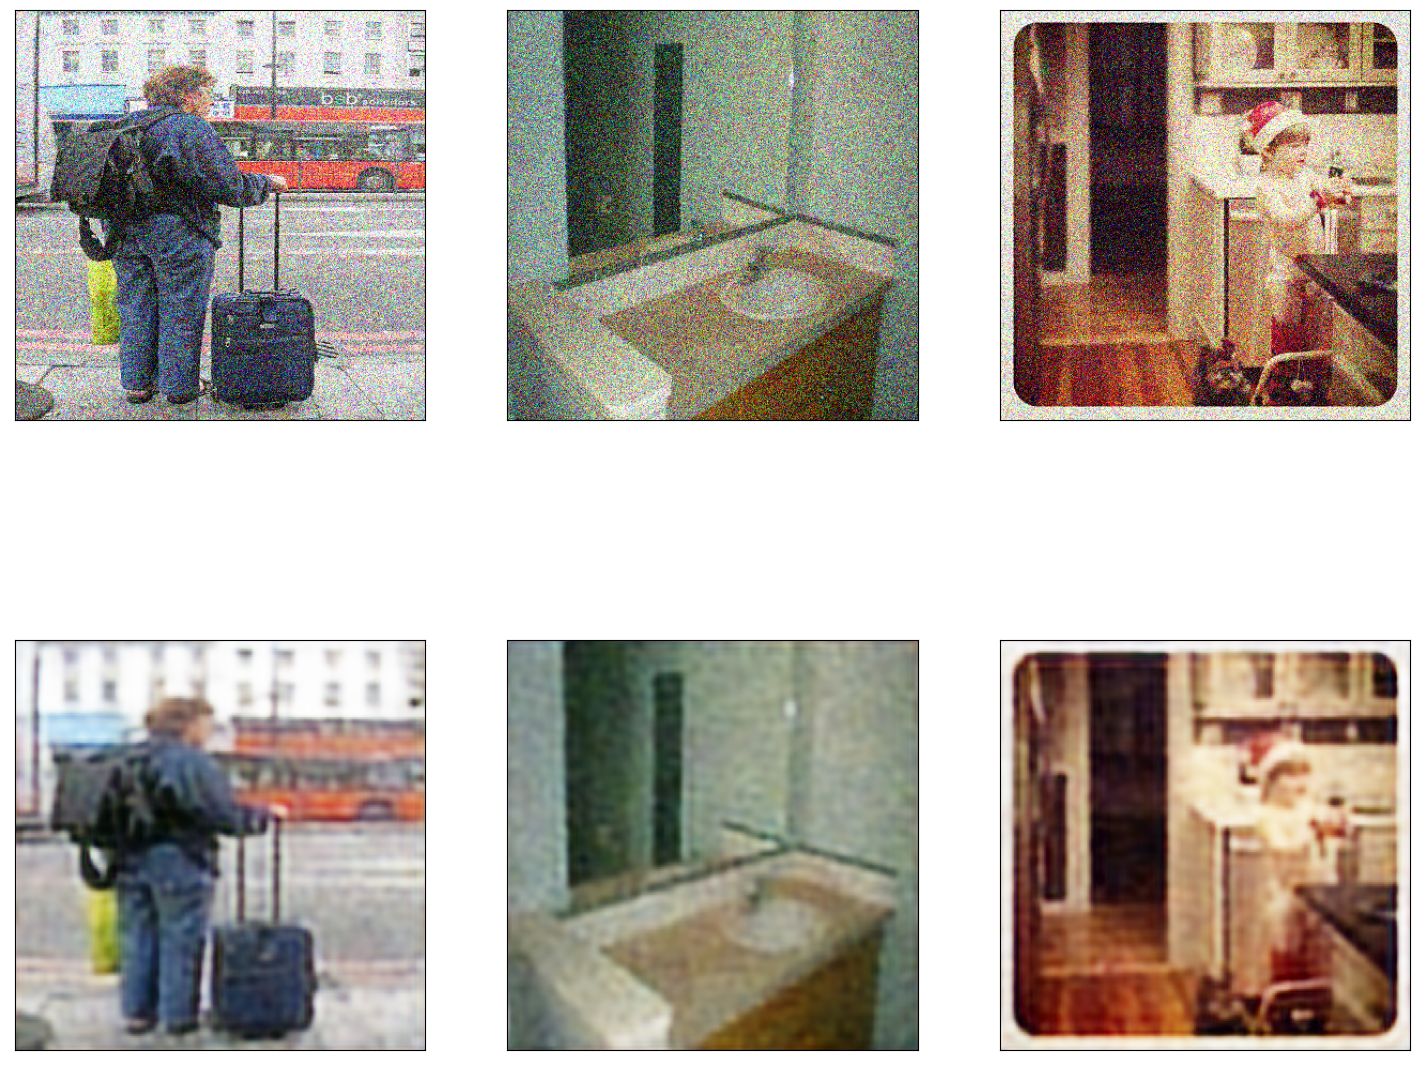

In [20]:
#x_test_noisy
#test_set

n = 3
plt.figure(figsize=(18, 15))

predictions = autoencoder.predict(x_test_noisy[:n])

for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i])
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### 3.2 VAE

## IV. Résultats et conclusion